# Overview
This script takes in an image and returns a list of coordinates of pixels which the centre of the robot should visit.

Variables which depend on the robot and setting: 
radius, colour channels

In [81]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle,Polygon
import copy
from scipy import stats
!pip install imutils
import imutils
from math import pi
import queue

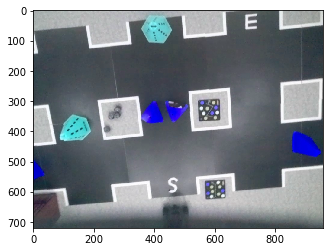

In [5]:
plt.imshow(cv2.imread("Arena/0.jpg"))
plt.show()

(1936, 2592, 3)


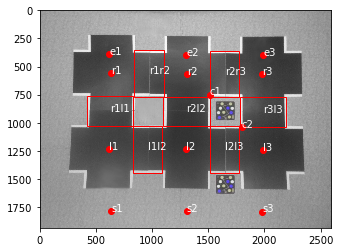

In [181]:
def to_rgb(img):
    return cv2.merge(cv2.split(img)[::-1])

base_image = cv2.imread("Arena/edited.png",cv2.COLOR_BGR2RGB)

class Node:
    def __init__(self, px, py, label):
        self.p = np.array([px,py])
        self.label = label
    def transform(self,c1,c2,d1,d2,rev=False):
        p = self.p.copy()
        p = p.astype("float32")
        
        c = (c1.p+c2.p)/2
        d = (d1.p+d2.p)/2
        #print(c,d)
        p += d-c
        #(c2-c) --> (d2-d)
        z = complex((d2.p-d)[0], (d2.p-d)[1]) / complex((c2.p-c)[0], (c2.p-c)[1])
        z *= complex((p-d)[0], (p-d)[1])
        p = np.array([z.real,z.imag]) + d
        n = copy.copy(self)
        n.p = p
        return n
#     def transform(self,mat):
#         res = copy.copy(self)
#         res.px,res.py = mat@np.array([[self.px],[self.py]])
#         res.px=int(res.px)
#         res.py=int(res.py)
#         return res
    def __repr__(self):
        return str(self.p[0])+','+str(self.p[1])+','+str(self.label)
    
class Edge:
    def __init__(self, n1, n2):
        if n1.label[0] == n2.label[0]: #same row
            w,h = 262.3375, 414.6625
        else:
            h,w = 262.3375, 414.6625
        self.w, self.h = w,h
        
        x,y = (n1.p[0]+n2.p[0])/2, (n1.p[1]+n2.p[1])/2
        self.x,self.y = x,y
        self.p = np.array([[x-w/2,y-h/2],[x-w/2,y+h/2],[x+w/2,y+h/2],[x+w/2,y-h/2]], dtype="int32")        
        self.label1 = n1.label
        self.label2 = n2.label
    def get_rect(self):
        return Rectangle(self.p[0],self.w,self.h,linewidth=1,edgecolor='r',facecolor='none')
    def get_polygon(self):
        return Polygon(self.p)
    def test_image(self,img,c1,c2,d1,d2): #https://www.pyimagesearch.com/2014/08/04/opencv-python-color-detection/
    
        mask_red = cv2.inRange(img, np.array([0,0,170]),np.array([50,50,255]))
        mask_yellow = cv2.inRange(img, np.array([0,170,170]),np.array([150,255,255]))
        mask_cones = cv2.bitwise_xor(mask_red, mask_yellow)
        output = cv2.bitwise_and(img, img, mask = mask_cones)
        
        mask_box = np.zeros(img.shape[:2], np.uint8)
        cv2.drawContours(mask_box, [self.transform(c1,c2,d1,d2).p], -1, (255, 255, 255), -1, cv2.LINE_AA)
        
        return (mask_cones&mask_box).any()
    def transform(self,c1,c2,d1,d2):
        e = copy.copy(self)
        e.p = np.array([Node(x,y,'').transform(c1,c2,d1,d2).p for x,y in self.p], dtype="int32")
        #ignore w,h
        return e
    def __repr__(self):
        return str(self.p)+','+str(self.label1)+','+str(self.label2)
#         plt.subplot(121),plt.imshow(to_rgb(mask_cones))
#         plt.title('Original Image'), plt.xticks([]), plt.yticks([])
#         plt.subplot(122),plt.imshow(to_rgb(mask_box))
#         plt.title('Inrange'), plt.xticks([]), plt.yticks([])
#         plt.show()
        
#         return output

#c1 = Node(967,899,'c1')
#c2 = Node(1647, 902, 'c2')
c1 = Node(1515,750,'c1')
c2 = Node(1800,1040, 'c2')

#NOTE: CHANGE COORDINATES OF E TO ALIGN WITH LOC

keynodes = [
    Node(636, 1936 - 1378, 'r1'),
    Node(1310, 1936 - 1372, 'r2'),
    Node(1982, 1936 - 1368, 'r3'),
    Node(618, 1936 - 701, 'l1'),
    Node(1304, 1936 - 698, 'l2'),
    Node(1992, 1936 - 694, 'l3'),
    c1,
    c2,
    Node(636, 1936 - 151, 's1'),
    Node(1310, 1936 - 148, 's2'),
    Node(1982, 1936 - 144, 's3'),
    Node(618, 1936 - 1547, 'e1'),
    Node(1304, 1936 - 1541, 'e2'),
    Node(1992, 1936 - 1537, 'e3'),
]
keyedges = [
    Edge(keynodes[0],keynodes[1]),
    Edge(keynodes[1],keynodes[2]),
    Edge(keynodes[3],keynodes[4]),
    Edge(keynodes[4],keynodes[5]),
    Edge(keynodes[0],keynodes[3]),
    Edge(keynodes[1],keynodes[4]),
    Edge(keynodes[2],keynodes[5]),
]

# img = cv2.imread("Arena/0.jpg")

# for node_ in keynodes:
#     node = node_.transform(c1,c2,d1,d2)
#     plt.scatter(node.p[0], node.p[1], c = 'r')
#     plt.annotate(node.label,(node.p[0],node.p[1]),c='w')

# for edge_ in keyedges:
#     edge = edge_.transform(c1,c2,d1,d2)
#     plt.gca().add_patch(edge.get_polygon())
#     plt.annotate(edge.label1+edge.label2,(edge.x,edge.y),c='w')

# plt.imshow(img)
# plt.show()

#keyedges[0].test_image(cv2.imread("Arena/edited.png"))
base_plot = plt.imshow(base_image)

for node in keynodes:
    plt.scatter(node.p[0], node.p[1], c = 'r')
    plt.annotate(node.label,(node.p[0],node.p[1]),c='w')
    
for edge in keyedges:
    plt.gca().add_patch(edge.get_rect())
    plt.annotate(edge.label1+edge.label2,(edge.x,edge.y),c='w')
print(base_image.shape)
plt.show()

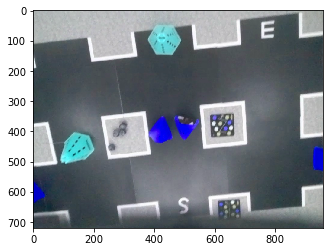

In [177]:
img = cv2.imread("Arena/6.jpg")
plt.imshow(img)
plt.show()

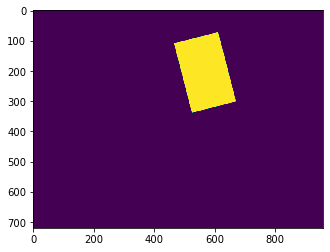

any True


In [191]:
mask_red = cv2.inRange(img, np.array([0,0,170]),np.array([50,50,255]))
mask_yellow = cv2.inRange(img, np.array([0,170,170]),np.array([150,255,255]))
mask_cones = cv2.bitwise_xor(mask_red, mask_yellow)
output = cv2.bitwise_and(img, img, mask = mask_cones)

d1_coords,d2_coords=getsquare(img)
d1 = Node(d1_coords[0], d1_coords[1], 'd1')
d2 = Node(d2_coords[0], d2_coords[1], 'd2')
    
mask_box = np.zeros(img.shape[:2], np.uint8)
cv2.drawContours(mask_box, [keyedges[1].transform(c1,c2,d1,d2).p], -1, (255, 255, 255), -1, cv2.LINE_AA)
plt.imshow(mask_box)
plt.show()
print('any',(mask_cones&mask_box).any())

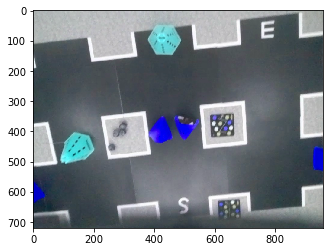

In [184]:
def find_blocked(img,d1_coords,d2_coords): #(x,y)
    d1 = Node(d1_coords[0], d1_coords[1], 'd1')
    d2 = Node(d2_coords[0], d2_coords[1], 'd2')
    
    blocked = []
    for edge_ in keyedges:
        edge = edge_.transform(c1,c2,d1,d2)
        if edge.test_image(img,c1,c2,d1,d2):
            blocked.append(edge_)
    
    #blocked = [(edge.label1,edge.label2) for edge in blocked]
    return blocked

img = cv2.imread("Arena/6.jpg")
d1,d2 = getsquare(img)
blocked = find_blocked(img,d1,d2)
for edge_ in blocked:
    edge = edge_.transform(c1,c2,Node(d1[0],d1[1],'d1'),Node(d2[0],d2[1],'d2'))
    plt.gca().add_patch(edge.get_polygon())
    plt.annotate('blocked',(edge.x,edge.y),c='w')
plt.imshow(img)
plt.show()

In [190]:
#https://stackoverflow.com/questions/55169645/square-detection-in-image
#https://stackoverflow.com/questions/14997733/advanced-square-detection-with-connected-region
def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def get_side(sq, i):
    return ((sq[i][0] - sq[(i+1)%4][0])**2 + (sq[i][1] - sq[(i+1)%4][1])**2)**0.5

def find_squares(img):
    img = cv2.GaussianBlur(img, (5, 5), 0)
    squares = []
    for gray in cv2.split(img):
        for thrs in range(0, 255, 26):
            if thrs == 0:
                bin = cv2.Canny(gray, 0, 50, apertureSize=5)
                bin = cv2.dilate(bin, None)
            else:
                _retval, bin = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
            contours, _hierarchy = cv2.findContours(bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv2.arcLength(cnt, True)
                cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
                if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                    #print(cnt)
                    a = (cnt[1][1] - cnt[0][1])

                    if max_cos < 0.1 and a < img.shape[0]*0.8:

                        squares.append(cnt)
    return squares

def sqsize(img):
    sqlist = find_squares(img)
    oksides = []
    for sq in sqlist:
        sides = [get_side(sq, i) for i in range(4)]
        if (max(sides) / min(sides) > 1.2):
            continue
        oksides.append(round(np.mean(sides)))
    oksides = sorted(oksides)
    return oksides[-3]

def getsquare(img):
    sqlist = find_squares(img)
    oksides = []
    for sq in sqlist:
        sides = [get_side(sq, i) for i in range(4)]
        if (max(sides) / min(sides) > 1.2):
            continue
        x = sum(x for x,y in sq) / 4
        if x<img.shape[1]/2: #Select squares on the right
            continue
        oksides.append((round(np.mean(sides)),sq))
    oksides = sorted(oksides,key=lambda x:x[0])
    sq = oksides[-1][1]
    d1 = min(sq, key=lambda t:t[0]+t[1])
    d2 = max(sq, key=lambda t:t[0]+t[1])
#     xmin = min(x for x,y in sq)
#     xmax = max(x for x,y in sq)
#     ymin = min(y for x,y in sq)
#     ymax = max(y for x,y in sq)
    #return sq
    return d1,d2

169.0


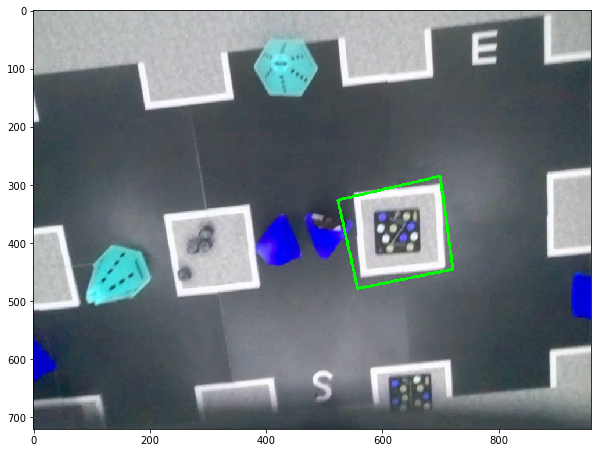

In [189]:
img1 = cv2.imread("Arena/6.jpg")

squares = find_squares(img1)
#print(getsquare(img1))
cv2.drawContours(img1, [getsquare(img1)], -1, (0, 255, 0), 3)
plt.figure(figsize = (10,10))
plt.imshow(img1)
print(sqsize(img1))
plt.show()

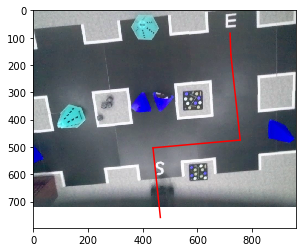

[[1516 1032]
 [1516 1447]
 [1779 1447]
 [1779 1032]],l2,l3


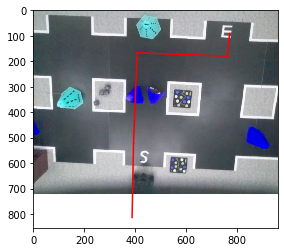

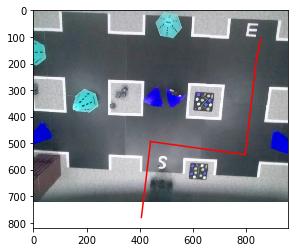

[[ 829 1029]
 [ 829 1443]
 [1092 1443]
 [1092 1029]],l1,l2


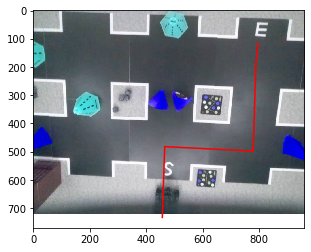

[[ 829 1029]
 [ 829 1443]
 [1092 1443]
 [1092 1029]],l1,l2


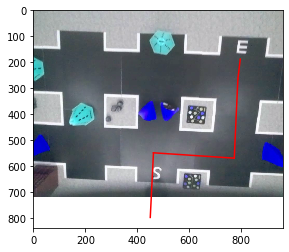

[[ 829 1029]
 [ 829 1443]
 [1092 1443]
 [1092 1029]],l1,l2


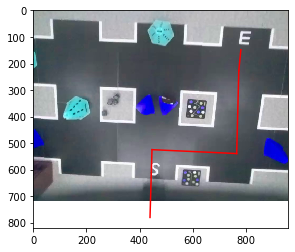

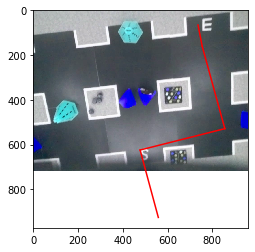

In [196]:
#[Actual(x,y),Image(x,y),Connections(+y,-y,+x,-x)]
loc = {
    's1':[(80,-25),(0,0),['l1','','','']],
    's2':[(160-25),(0,0),['l2','','','']],
    's3':[(240,-25),(0,0),['l3','','','']],

    #'l0':[(0,40),(0,0),('r0','','l1','')],
    'l1':[(80,40),(0,0),['r1','','l2','']],
    'l2':[(160,40),(0,0),['r2','','l3','l1']],
    'l3':[(240,40),(0,0),['r3','','','l2']],
    #'l4':[(320,40),(0,0),('r4','','','l3')],
    
    #'r0':[(0,120),(0,0),('e0','l0','r1','')],
    'r1':[(80,120),(0,0),['e1','','r2','']],
    'r2':[(160,120),(0,0),['e2','','r3','r1']],
    'r3':[(240,120),(0,0),['e3','','','r2']],
    #'r4':[(320,120),(0,0),('e4','l4','','r3')],
    
    #'e0':[(0,160),(0,0),('','r0','','')],
    'e1':[(80,140),(0,0),['','','','']],
    'e2':[(160,140),(0,0),['','','','']],
    'e3':[(240,140),(0,0),['','','','']],
    #'e4':[(320,160),(0,0),('','r4','','')],
}

def gen_graph(blocked):
    adj = {}
    for edge in keyedges:
        if edge in blocked:
            continue
        n1 = edge.label1
        n2 = edge.label2
        if n1 not in adj: adj[n1]=[]
        if n2 not in adj: adj[n2]=[]
        adj[n1].append(n2)
        adj[n2].append(n1)
    for n1,n2 in [('s1','l1'),('s2','l2'),('s3','l3'),('r1','e1'),('r2','e2'),('r3','e3')]:
        if n1 not in adj: adj[n1]=[]
        if n2 not in adj: adj[n2]=[]
        adj[n1].append(n2)
        adj[n2].append(n1)
    return adj

import queue
def find_path(img,start,end):
    d1,d2 = getsquare(img)
    blocked = find_blocked(img,d1,d2)
    adj = gen_graph(blocked)
    vis = []
    prev = {}
    for node in keynodes: prev[node]="-1"
    q = queue.Queue()
    q.put(start)
    while not q.empty():
        v = q.get()
        for i in adj[v]:
            if i in vis:
                continue
            vis.append(i)
            prev[i]=v
            q.put(i)
    
    path = [end]
    while path[-1]!=start:
        v = path[-1]
        if prev[v]=="-1":
            print("No path found!")
            assert False
        path.append(prev[v])
    path.reverse()
    return path

def robot_move(robot,n1,n2):
    p1 = loc[n1][0]
    p2 = loc[n2][0]
    #x and y are flipped
    y = p2[0] - p1[0]
    x = p2[1] - p1[1]
    if abs(x) > 0.01: 
        robot.move(f'x {x/100.0} y 0 vxy 0.3')
        sleep(3)
    if abs(y) > 0.01:
        robot.move(f'x 0 y {y/100.0} vxy 0.3')
        sleep(3)
        
def execute_path(robot,path):
    for i in range(len(path)-1):
        robot_move(robot,path[i],path[i+1])

def plot_path(img,path):
    d1,d2 = getsquare(img)
    plt.imshow(img)
    for i in range(len(path)-1):
        n1 = [n for n in keynodes if n.label==path[i]][0].transform(c1,c2,Node(d1[0],d1[1],''),Node(d2[0],d2[1],''))
        n2 = [n for n in keynodes if n.label==path[i+1]][0].transform(c1,c2,Node(d1[0],d1[1],''),Node(d2[0],d2[1],''))
        plt.plot([n1.p[0],n2.p[0]],[n1.p[1],n2.p[1]],c='r')
    plt.show()

for i in range(7):
    img=cv2.imread("Arena/{}.jpg".format(i))
    path=find_path(img,'s2','e3')
    plot_path(img,path)

# img=cv2.imread("Arena/A.png")
# path=find_path(img,'s2','e3')
# plot_path(img,path)

In [100]:
class PathFinder:
    def __init__(self, imagename):
        self.img = cv2.imread(imagename)
        self.img_contours = None
        self.processed = None
        self.dx = (-1,0,0,1)
        self.dy = (0,-1,1,0)
        self.theta = 0
        
    def display(self):
        print("Displaying original image, image contours and processed image")
        plt.imshow(self.img)
        plt.figure()
        plt.imshow(self.img_contours)
        plt.figure()
        plt.imshow(self.processed)
        plt.figure()
        
    def rotate(self, hough_thr):
        #rotates images based on mode angle of detected lines
        gray_img = cv2.cvtColor(self.img,cv2.COLOR_BGR2GRAY)
        #50 and 100 represent two thresholds
        #see https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny
        edges = cv2.Canny(gray_img,50,150,apertureSize = 3)
        lines = cv2.HoughLines(edges,1,np.pi/180,hough_thr)
        angles = []
        for line in lines:
            for rho,theta in line:
                if (theta < pi/4 or pi - theta < pi/4):
                    if theta > pi/2: angles.append(round(theta - pi, 2))
                    else: angles.append(round(theta, 2))
                    
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))
                cv2.line(gray_img,(x1,y1),(x2,y2),255,2)
        '''
        mode_angle = stats.mode(np.array(angles))[0] * 180 / pi
        #print(mode_angle)
        if (mode_angle > 90): mode_angle -= 180
        self.img = imutils.rotate_bound(self.img, -mode_angle)
        self.theta = mode_angle
        '''
        mean_angle = np.mean(np.array(angles)) * 180 / pi
        self.img = imutils.rotate_bound(self.img, -mean_angle)
        self.theta = mean_angle
    
    def calibrate(self):
        self.pixel = 44/sqsize(self.img)
        return self.pixel

    def get_contours(self, channel, contour_thr):
        img_chan = self.img[:,:,channel]
        ret,thresh_img = cv2.threshold(img_chan, contour_thr, 255, cv2.THRESH_BINARY)
        contours = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
        #print(contours[0].shape)
        return contours
    
    def draw_contours(self):
        self.img_contours = np.zeros(self.img.shape[:2])
        cv2.drawContours(self.img_contours, self.get_contours(0, 220), -1, 1, 3)
        cv2.drawContours(self.img_contours, self.get_contours(1, 220), -1, 1, 3)
        cv2.drawContours(self.img_contours, self.get_contours(2, 220), -1, 1, 3)
        
    def expand(self, radius):
        #radius is the number of pixels occupied by the half length of the robot
        self.processed = np.zeros(self.img.shape[:2])
        height = self.img.shape[0]
        width = self.img.shape[1]
        for x in range(height):
            for y in range(width):
                if self.img_contours[x,y]==0: continue
                self.processed[max(x-radius,0):min(x+radius,height), max(y-radius,0):min(y+radius,width)] = 1
    
    def genDistFromWalls(self):
        xmax,ymax = self.processed.shape
        dist = np.full(self.processed.shape,-1)
        prev = np.full(self.processed.shape+(2,),-1)
        q = queue.Queue()
        for x in range(xmax):
            for y in range(ymax):
                if self.processed[x][y] == 1: #Colour of wall
                    dist[x][y] = 0
                    q.put((x,y))

        while not q.empty():
            x,y = q.get()
            for i in range(4):
                nx,ny = x+self.dx[i], y+self.dy[i]
                if nx<0 or nx>=xmax or ny<0 or ny>=ymax:
                    continue
                if dist[nx][ny] != -1:
                    continue
                dist[nx][ny] = dist[x][y]+1
                prev[nx][ny] = (x,y)
                q.put((nx,ny))
        return dist
    
    def dijkstra(self, start, end, edge_weight=lambda x,y:1000/x):
        self.start = start
        self.end = end
        xmax,ymax = self.processed.shape
        xstart,ystart = start
        xend,yend = end
        assert(self.processed[xstart][ystart] == 0)
        assert(self.processed[xend][yend] == 0)
        dist_walls=self.genDistFromWalls()

        dist = np.full(self.processed.shape,-1.0)
        prev = np.full(self.processed.shape+(2,),-1)
        
        q = queue.PriorityQueue()
        dist[xstart][ystart] = 0
        q.put((0,xstart,ystart))

        while not q.empty():
            d,x,y = q.get()
            if d != dist[x][y]:
                continue
            for i in range(4):
                nx,ny = x+self.dx[i], y+self.dy[i]
                if nx<0 or nx>=xmax or ny<0 or ny>=ymax:
                    continue
                if self.processed[nx][ny] != self.processed[xstart][ystart]:
                    continue
                nd = d+1+edge_weight(dist_walls[nx][ny], tuple(prev[x][y]) == (x-self.dx[i],y-self.dy[i]))
                if dist[nx][ny] == -1 or dist[nx][ny] > nd:
                    dist[nx][ny] = nd
                    prev[nx][ny] = (x,y)
                    q.put((nd,nx,ny))

        path = [(xend,yend)]
        while path[-1] != (xstart,ystart):
            if path[-1] == (-1,-1):
                print("No path found!")
                break
            x,y = path[-1]
            path.append(tuple(prev[x][y]))
        path.reverse()
        
        self.dist, self.prev, self.path = dist,prev,path
    
    def plot_path(self):
        xstart,ystart = self.start
        xend,yend = self.end

        plt.imshow(self.dist, cmap='hot', interpolation='nearest')
        plt.text(ystart,xstart,'S',color='g',bbox=dict(fill=False, edgecolor='green', linewidth=2))
        plt.text(yend,xend,'E',color='b',bbox=dict(fill=False, edgecolor='blue', linewidth=2))

        x,y = list(zip(*self.path))
        plt.scatter(y,x,s=1,c='purple')

        plt.show()
    
    def gen_instructions(self):
        instructions = [[self.path[0], np.subtract(self.path[1], self.path[0])]]
        for i in range(1,len(self.path)-1):
            prev, cur, nxt = self.path[i-1], self.path[i], self.path[i+1]
            if (np.array_equal(np.subtract(cur, prev), np.subtract(nxt, cur)) == False):
                instructions.append([cur, np.subtract(nxt, cur)])
        instructions.append([self.end, None])
        for i in range(len(instructions) - 1):
            dist = np.abs(instructions[i+1][0][0] - instructions[i][0][0]) + np.abs(instructions[i+1][0][1] - instructions[i][0][1])
            instructions[i].append(dist)
        return instructions

    def robot_instruct(self):
        instructions = [[self.path[0], np.subtract(self.path[1], self.path[0])]]
        for i in range(1,len(self.path)-1):
            prev, cur, nxt = self.path[i-1], self.path[i], self.path[i+1]
            if (np.array_equal(np.subtract(cur, prev), np.subtract(nxt, cur)) == False):
                instructions.append([cur, np.subtract(nxt, cur)])
        instructions.append([self.end, None])
        for i in range(len(instructions) - 1):
            dist = np.abs(instructions[i+1][0][0] - instructions[i][0][0]) + np.abs(instructions[i+1][0][1] - instructions[i][0][1])
            instructions[i].append(dist)
        return instructions
        

136.0
(12, 1, 2)
(9, 1, 2)
(10, 1, 2)
Displaying original image, image contours and processed image


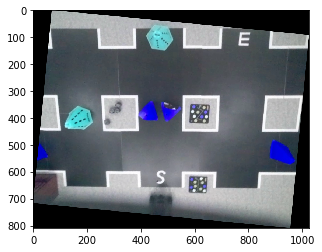

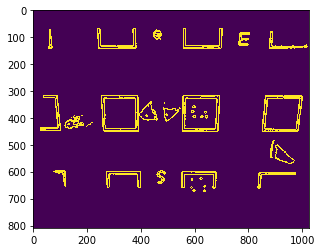

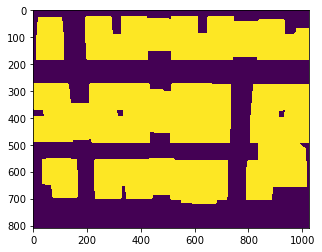

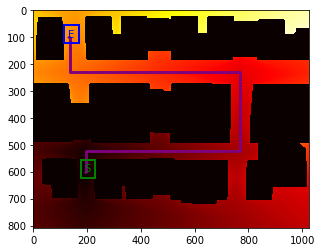

In [47]:
solver = PathFinder("Arena/0.jpg")
solver.rotate(100)
print(44/solver.calibrate())
solver.draw_contours()
#this value is dependent on the pixel width
solver.expand(int(14 / solver.pixel))
solver.display()

solver.dijkstra((600, 190), (100, 130), lambda x,y:100/x*(0.20 if y else 1))
#1000 and 0.20 can be tuned

solver.plot_path()

In [5]:
#generates a list of coordinates, directions and distances
solver.gen_instructions()

[[(600, 190), array([0, 1]), 6],
 [(600, 196), array([-1,  0]), 77],
 [(523, 196), array([0, 1]), 572],
 [(523, 768), array([-1,  0]), 294],
 [(229, 768), array([ 0, -1]), 633],
 [(229, 135), array([-1,  0]), 129],
 [(100, 135), array([ 0, -1]), 5],
 [(100, 130), None]]

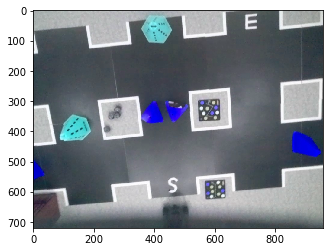

In [6]:
img1 = cv2.imread("Arena/0.jpg")
plt.imshow(img1)

In [18]:
img2 = cv2.imread("Arena/4.jpg")

oksides = getsquare(img2)
square1 = oksides[-3][1]
square2 = oksides[-2][1]
cv2.drawContours(img2, [square1], -1, (0, 255, 0), 3)
cv2.drawContours(img2, [square2], -1, (0, 255, 0), 3)
plt.figure(figsize = (10,10))
plt.imshow(img2)
print(sqsize(img2))

TypeError: contours is not a numpy array, neither a scalar